# Gaze Estimation with UniFace

This notebook demonstrates gaze estimation using the **UniFace** library.

## 1. Install UniFace

In [1]:
%pip install -q uniface

Note: you may need to restart the kernel to use updated packages.


## 2. Import Libraries

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

import uniface
from uniface.detection import RetinaFace
from uniface.gaze import MobileGaze
from uniface.visualization import draw_gaze

print(f"UniFace version: {uniface.__version__}")

UniFace version: 1.6.0


## 3. Initialize Models

In [ ]:
# Initialize face detector
detector = RetinaFace(confidence_threshold=0.5)

# Initialize gaze estimator (uses ResNet34 by default)
gaze_estimator = MobileGaze()

✓ Model loaded (CoreML (Apple Silicon))
✓ Model loaded (CoreML (Apple Silicon))


## 4. Process All Test Images

Display original images in the first row and gaze-annotated images in the second row.

In [4]:
# Get all test images
test_images_dir = Path('../assets/test_images')
test_images = sorted(test_images_dir.glob('*.jpg'))

# Store original and processed images
original_images = []
processed_images = []

for image_path in test_images:
    print(f"Processing: {image_path.name}")

    # Load image
    image = cv2.imread(str(image_path))
    original = image.copy()

    # Detect faces
    faces = detector.detect(image)
    print(f'  Detected {len(faces)} face(s)')

    # Estimate gaze for each face
    for i, face in enumerate(faces):
        x1, y1, x2, y2 = map(int, face.bbox[:4])
        face_crop = image[y1:y2, x1:x2]

        if face_crop.size > 0:
            pitch, yaw = gaze_estimator.estimate(face_crop)
            pitch_deg = np.degrees(pitch)
            yaw_deg = np.degrees(yaw)

            print(f'    Face {i+1}: pitch={pitch_deg:.1f}°, yaw={yaw_deg:.1f}°')

            # Draw gaze without angle text
            draw_gaze(image, face.bbox, pitch, yaw, draw_angles=False)

    # Convert BGR to RGB for display
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    processed_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    original_images.append(original_rgb)
    processed_images.append(processed_rgb)

print(f"\nProcessed {len(test_images)} images")

Processing: image0.jpg
  Detected 1 face(s)
    Face 1: pitch=-0.0°, yaw=7.1°
Processing: image1.jpg
  Detected 1 face(s)
    Face 1: pitch=-3.3°, yaw=-5.6°
Processing: image2.jpg
  Detected 1 face(s)
    Face 1: pitch=-3.9°, yaw=-0.3°
Processing: image3.jpg
  Detected 1 face(s)
    Face 1: pitch=-22.1°, yaw=1.0°
Processing: image4.jpg
  Detected 1 face(s)
    Face 1: pitch=2.1°, yaw=5.0°

Processed 5 images


## 5. Visualize Results

**First row**: Original images  
**Second row**: Images with gaze direction arrows

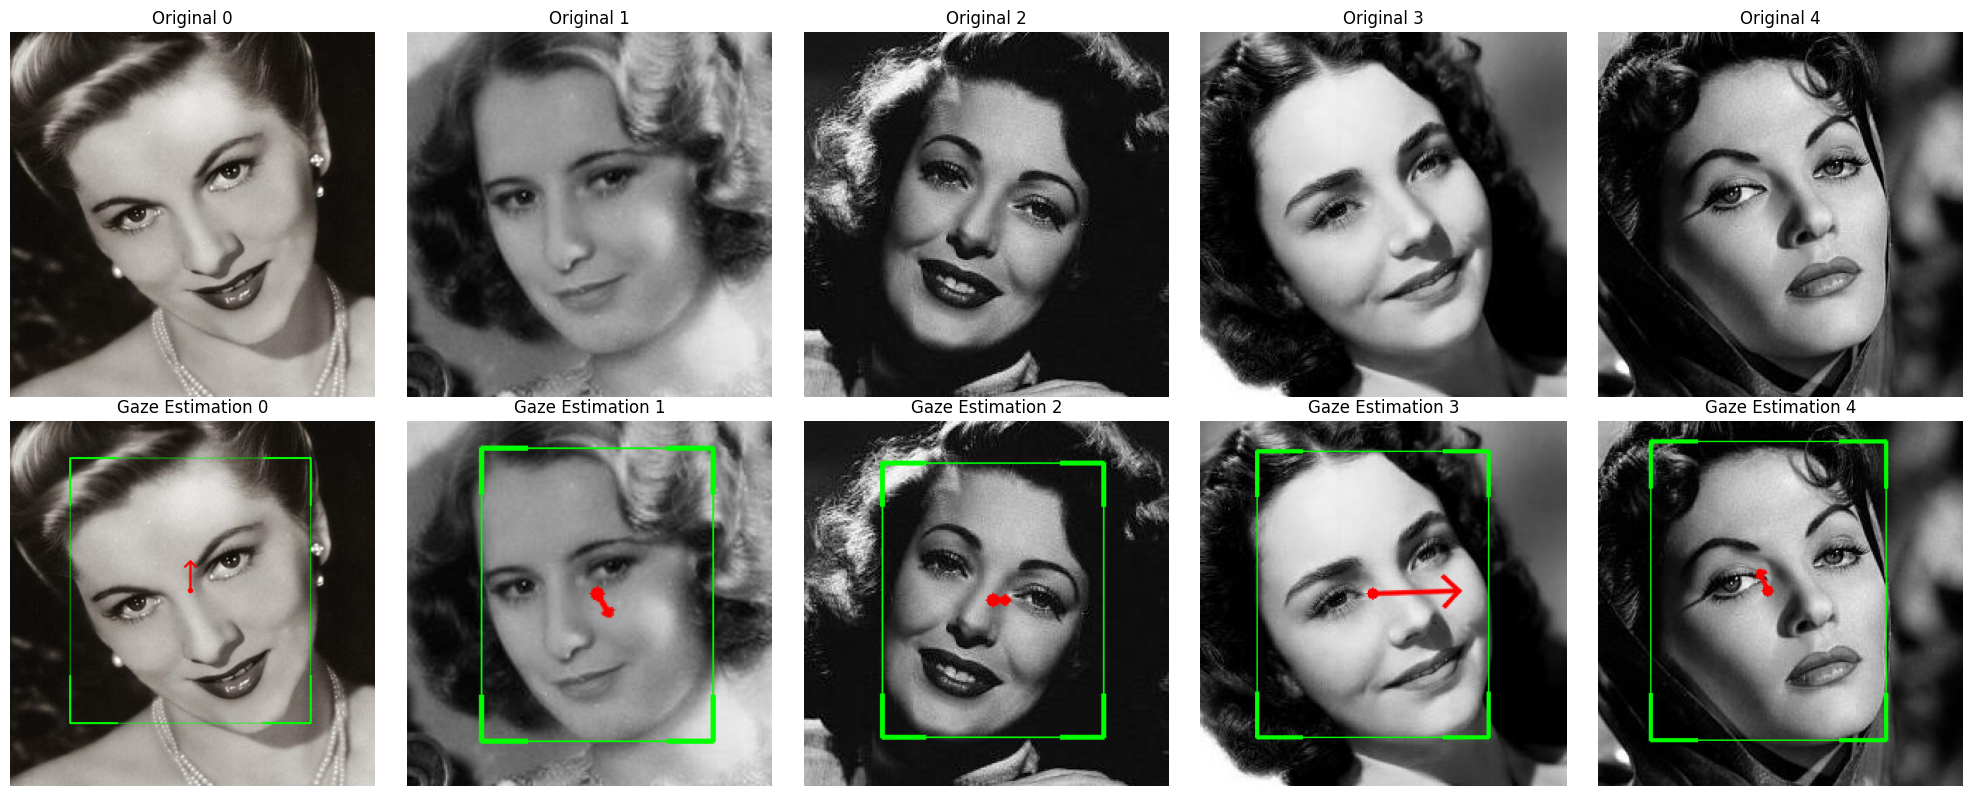

In [5]:
num_images = len(original_images)

# Create figure with 2 rows
fig, axes = plt.subplots(2, num_images, figsize=(4*num_images, 8))

# Handle case where there's only one image
if num_images == 1:
    axes = axes.reshape(2, 1)

# First row: Original images
for i, img in enumerate(original_images):
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Original {i}', fontsize=12)
    axes[0, i].axis('off')

# Second row: Gaze-annotated images
for i, img in enumerate(processed_images):
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Gaze Estimation {i}', fontsize=12)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## Notes

- **Input**: Gaze estimation requires a face crop (obtained from face detection)
- **Output**: Returns (pitch, yaw) angles in radians
- **Visualization**: `draw_gaze()` automatically draws bounding box and gaze arrow
- **Models**: Trained on Gaze360 dataset with diverse head poses
- **Performance**: MAE (Mean Absolute Error) ranges from 11-13 degrees

### Tips for Best Results
- Ensure faces are clearly visible and well-lit
- Works best with frontal to semi-profile faces
- Accuracy may vary with extreme head poses or occlusions